# Data Processing

## Game finding

In [ ]:
from nba_api.stats.endpoints import leaguegamefinder

seasons = ['2023-24', '2022-23', '2021-22']

# Initialize an empty list to store game IDs
all_game_ids = []

# Loop through each season and collect game IDs
for season in seasons:
    game_finder = leaguegamefinder.LeagueGameFinder(season_nullable=season)
    games = game_finder.get_data_frames()[0]
    game_ids = games['GAME_ID'].unique()
    all_game_ids.extend(game_ids)
len(all_game_ids)

## Player finding

In [28]:
from nba_api.stats.endpoints import leaguedashplayerstats

def get_players_for_season(season_str):
    # season_str format: 'YYYY-YY', e.g. '2023-24'
    stats = leaguedashplayerstats.LeagueDashPlayerStats(season=season_str)
    df = stats.get_data_frames()[0]
    # 'PLAYER_ID' in this DataFrame gives you the unique ID of each player who played that season
    player_ids = df['PLAYER_ID'].unique()
    return set(player_ids)

# Get player sets for each season
players_2023_24 = get_players_for_season('2023-24')
players_2022_23 = get_players_for_season('2022-23')
players_2021_22 = get_players_for_season('2021-22')

# Combine them into one set of unique player IDs
all_players = players_2023_24.union(players_2022_23).union(players_2021_22)
len(all_players)

818

## Outcome codes
0.	2-point unassisted
1.	2-point assisted
2.	3-point unassisted
3.	3-point assisted

6. Missed (blocked)
7. Missed (unblocked)

8. Turnover (stolen)
9. Turnover (unforced or not stolen)

10. Possession ends with 0 FTs made
11. Possession ends with 1 FTs made
12. Possession ends with 2 FTs made
13. Possession ends with 3 FTs made

## generate a single raw pbp file

In [1]:
import nba_on_court as noc
from nba_api.stats.endpoints import playbyplayv2
pbp = playbyplayv2.PlayByPlayV2(game_id='0022200992').play_by_play.get_data_frame()
pbp = noc.players_on_court(pbp)
# filtered_pbp = pbp[pbp['EVENTMSGTYPE'].isin(valid_event_types)].copy()
pbp.to_csv("0022200992.csv")

## Generate a single processed pbp

In [1]:
game_id = "0022301158"
import nba_on_court as noc
from nba_api.stats.endpoints import playbyplayv2
import pandas as pd
import numpy as np
import re

# Define the event message types that matter
FIELD_GOAL_MADE = 1
FIELD_GOAL_MISSED = 2
FREE_THROW_ATTEMPT = 3
REBOUND = 4
TURNOVER = 5

valid_event_types = {FIELD_GOAL_MADE, FIELD_GOAL_MISSED, FREE_THROW_ATTEMPT, REBOUND, TURNOVER}

columns = [
    "OFF_PLAYER1_ID", "OFF_PLAYER2_ID", "OFF_PLAYER3_ID", "OFF_PLAYER4_ID", "OFF_PLAYER5_ID",
    "DEF_PLAYER1_ID", "DEF_PLAYER2_ID", "DEF_PLAYER3_ID", "DEF_PLAYER4_ID", "DEF_PLAYER5_ID",
    "OUTCOME",         # One of the 12 categories described (e.g., "2PT_ASSIST", "MISSED_BLOCKED", etc.)
    "SECOND_CHANCE",    # 0 or 1
    "SHOOTER_ID",       # ID of the player who took the shot (if applicable)
    "ASSISTER_ID",      # ID of the player who assisted (if applicable)
    "BLOCKER_ID",       # ID of the player who blocked the shot (if applicable)
    "STEALER_ID",       # ID of the player who stole the ball (if applicable)
    "REBOUNDER_ID" ,    # ID of the player who rebound the ball (if applicable)
    "TURNOVER_ID"      # ID of the player who turnover the ball (if applicable)
]

pbp = playbyplayv2.PlayByPlayV2(game_id=game_id).play_by_play.get_data_frame()
pbp = noc.players_on_court(pbp)

filtered_pbp = pbp[pbp['EVENTMSGTYPE'].isin(valid_event_types)].copy()
filtered_pbp = filtered_pbp.reset_index(drop=True)

# player_columns = [
#     "AWAY_PLAYER1", "AWAY_PLAYER2", "AWAY_PLAYER3", "AWAY_PLAYER4", "AWAY_PLAYER5",
#     "HOME_PLAYER1", "HOME_PLAYER2", "HOME_PLAYER3", "HOME_PLAYER4", "HOME_PLAYER5"
# ]
# # Filter rows so that all on-court players are in player_id_set
# mask = filtered_pbp[player_columns].isin(all_players).all(axis=1)
# filtered_pbp = filtered_pbp[mask].copy()

# Now we have only the rows we care about.
# We can iterate through these rows and handle each event type as needed.

processed_pbp = pd.DataFrame(columns=columns)
rows = []

def get_off_def_players(row):
    away_players = [row['AWAY_PLAYER1'], row['AWAY_PLAYER2'], row['AWAY_PLAYER3'], row['AWAY_PLAYER4'], row['AWAY_PLAYER5']]
    home_players = [row['HOME_PLAYER1'], row['HOME_PLAYER2'], row['HOME_PLAYER3'], row['HOME_PLAYER4'], row['HOME_PLAYER5']]
    
    if row['PERSON1TYPE'] == 5:
        # Away is offense
        off_players = away_players
        def_players = home_players
    elif row['PERSON1TYPE'] == 4:
        # Home is offense
        off_players = home_players
        def_players = away_players
    else:
        # Unexpected case
        off_players = [np.nan]*5
        def_players = [np.nan]*5
    
    return off_players, def_players

def check_and_one(pbp, current_idx, shooter_id):
    # Look ahead for next free throw attempt by the same shooter
    next_events = pbp.iloc[current_idx+1:]
    for i, r in next_events.iterrows():
        if r['EVENTMSGTYPE'] == FREE_THROW_ATTEMPT and r['PLAYER1_ID'] == shooter_id:
            # Check if made free throw
            desc = (r['HOMEDESCRIPTION'] if pd.notnull(r['HOMEDESCRIPTION']) else '') + \
                   (r['VISITORDESCRIPTION'] if pd.notnull(r['VISITORDESCRIPTION']) else '')
            if "MISS" not in desc.upper():
                # FT made => and-one
                return True
            else:
                return False
    return False

for idx, row in filtered_pbp.iterrows():
    event_type = row['EVENTMSGTYPE']
    off_players, def_players = get_off_def_players(row)
    
    # Switch-like structure to handle cases
    if event_type == FIELD_GOAL_MADE:
        # Determine if 2pt or 3pt
        desc = (row['HOMEDESCRIPTION'] if pd.notnull(row['HOMEDESCRIPTION']) else '') + \
               (row['VISITORDESCRIPTION'] if pd.notnull(row['VISITORDESCRIPTION']) else '')
        desc_upper = desc.upper()
        is_3pt = "3PT" in desc_upper

        # Determine assisted or unassisted
        assisted = (row['PERSON2TYPE'] == 4 or row['PERSON2TYPE'] == 5)

        # Base outcome mapping
        # 0: 2-point unassisted
        # 1: 2-point assisted
        # 2: 3-point unassisted
        # 3: 3-point assisted
        if not is_3pt:
            base_outcome = 1 if assisted else 0
        else:
            base_outcome = 3 if assisted else 2

        shooter_id = row['PLAYER1_ID']
        assister_id = row['PLAYER2_ID'] if assisted else np.nan

        # Check for and-one
        if check_and_one(filtered_pbp, idx, shooter_id):
            # 4-point scenarios for both 2pt+1 or 3pt+1
            # If base_outcome in [0,2] => unassisted => outcome=4
            # If base_outcome in [1,3] => assisted => outcome=5
            if base_outcome in [0, 2]:
                final_outcome = 4
            else:
                final_outcome = 5
        else:
            final_outcome = base_outcome

        data = {
            "OFF_PLAYER1_ID": off_players[0],
            "OFF_PLAYER2_ID": off_players[1],
            "OFF_PLAYER3_ID": off_players[2],
            "OFF_PLAYER4_ID": off_players[3],
            "OFF_PLAYER5_ID": off_players[4],
            "DEF_PLAYER1_ID": def_players[0],
            "DEF_PLAYER2_ID": def_players[1],
            "DEF_PLAYER3_ID": def_players[2],
            "DEF_PLAYER4_ID": def_players[3],
            "DEF_PLAYER5_ID": def_players[4],
            "OUTCOME": final_outcome,
            "SECOND_CHANCE": 0, # Not computed here
            "SHOOTER_ID": shooter_id,
            "ASSISTER_ID": assister_id,
            "BLOCKER_ID": np.nan,
            "STEALER_ID": np.nan,
            "REBOUNDER_ID": np.nan,
            "TURNOVER_ID": np.nan
        }
        rows.append(data)

    elif event_type == FIELD_GOAL_MISSED:       
        # Check if blocked
        # If PERSON3TYPE and PLAYER3_ID indicate a block, outcome=6 (blocked), else 7 (unblocked)
        blocked = False
        blocker_id = np.nan
        if row['PERSON3TYPE'] in [4,5] and pd.notnull(row['PLAYER3_ID']) and row['PLAYER3_ID'] != 0:
            # ADDITION: Check if PLAYER3_NAME is present and not empty
            if pd.isnull(row['PLAYER3_NAME']) or row['PLAYER3_NAME'].strip() == '':
                # If no player name, treat as not blocked
                blocked = False
                blocker_id = np.nan
            else:
                blocked = True
                blocker_id = row['PLAYER3_ID']
        
        if blocked:
            final_outcome = 6  # Missed (blocked)
        else:
            final_outcome = 7  # Missed (unblocked)
        
        shooter_id = row['PLAYER1_ID']
        
        # Now find the rebound after this miss
        # Scan subsequent events for the next rebound (EVENTMSGTYPE=4)
        rebounder_id = np.nan
        second_chance = 0
        
        next_events = filtered_pbp.iloc[idx+1:]
        
        for i, r in next_events.iterrows():
            if r['EVENTMSGTYPE'] == REBOUND:
                # ADDITION: Check if PLAYER1_NAME is present and not empty
                if pd.isnull(r['PLAYER1_NAME']) or r['PLAYER1_NAME'].strip() == '':
                    # If no player name, this is a team rebound, skip
                    continue
                # Found the rebound with a player name
                rebounder_id = r['PLAYER1_ID']
                # Offensive or defensive?
                if rebounder_id in off_players:
                    second_chance = 1
                else:
                    second_chance = 0
                break
        
        data = {
            "OFF_PLAYER1_ID": off_players[0],
            "OFF_PLAYER2_ID": off_players[1],
            "OFF_PLAYER3_ID": off_players[2],
            "OFF_PLAYER4_ID": off_players[3],
            "OFF_PLAYER5_ID": off_players[4],
            "DEF_PLAYER1_ID": def_players[0],
            "DEF_PLAYER2_ID": def_players[1],
            "DEF_PLAYER3_ID": def_players[2],
            "DEF_PLAYER4_ID": def_players[3],
            "DEF_PLAYER5_ID": def_players[4],
            "OUTCOME": final_outcome,
            "SECOND_CHANCE": second_chance,
            "SHOOTER_ID": shooter_id,
            "ASSISTER_ID": np.nan,   # Not applicable for missed shots
            "BLOCKER_ID": blocker_id,
            "STEALER_ID": np.nan,
            "REBOUNDER_ID": rebounder_id,
            "TURNOVER_ID": np.nan
        }
        rows.append(data)

    elif event_type == FREE_THROW_ATTEMPT:
        # Parse the number of attempts from the first FT in the sequence
        shooter_id = row['PLAYER1_ID']
        desc = (row['HOMEDESCRIPTION'] if pd.notnull(row['HOMEDESCRIPTION']) else '') + \
               (row['VISITORDESCRIPTION'] if pd.notnull(row['VISITORDESCRIPTION']) else '')
        desc_up = desc.upper()

        match = re.search(r'FREE THROW.*?(\d+)\s+OF\s+(\d+)', desc_up)
        if not match:
            continue
        total_fts = int(match.group(2))
        if total_fts not in [2, 3]:
            # Not a scenario we care about
            continue

        # We'll accumulate all consecutive FTs for this shooter
        made_count = 0
        final_attempt_idx = None

        j = idx
        # Use a while loop to iterate through consecutive free throws of the same shooter
        while j in filtered_pbp.index:
            fr = filtered_pbp.loc[j]
            if fr['EVENTMSGTYPE'] != FREE_THROW_ATTEMPT or fr['PLAYER1_ID'] != shooter_id:
                # Different event or different shooter means end of FT sequence
                break

            f_desc = (fr['HOMEDESCRIPTION'] if pd.notnull(fr['HOMEDESCRIPTION']) else '') + \
                     (fr['VISITORDESCRIPTION'] if pd.notnull(fr['VISITORDESCRIPTION']) else '')
            f_desc_up = f_desc.upper()
            m2 = re.search(r'FREE THROW.*?(\d+)\s+OF\s+(\d+)', f_desc_up)
            if not m2:
                # Can't parse this attempt, stop
                break

            c_ft_num = int(m2.group(1))
            t_fts = int(m2.group(2))
            if t_fts not in [2, 3]:
                # Different scenario than expected
                break

            # Check if made
            if "MISS" not in f_desc_up:
                made_count += 1

            if c_ft_num == t_fts:
                # final attempt found
                final_attempt_idx = j
                break

            j += 1

        if final_attempt_idx is None:
            # No final attempt found
            continue

        # Determine outcome based on made_count
        # 0 made -> 10
        # 1 made -> 11
        # 2 made -> 12
        # 3 made -> 13
        if made_count == 0:
            final_outcome = 10
        elif made_count == 1:
            final_outcome = 11
        elif made_count == 2:
            final_outcome = 12
        elif made_count == 3:
            final_outcome = 13
        else:
            # Unexpected
            continue

        # Check if final attempt missed
        second_chance = 0
        rebounder_id = np.nan
        if made_count < total_fts:
            # last attempt missed
            next_after_ft = filtered_pbp.loc[final_attempt_idx+1:]
            for k, rb in next_after_ft.iterrows():
                if rb['EVENTMSGTYPE'] == REBOUND:
                    if pd.isnull(rb['PLAYER1_NAME']) or rb['PLAYER1_NAME'].strip() == '':
                        # team rebound, skip
                        continue
                    rebounder_id = rb['PLAYER1_ID']
                    # If offensive rebound
                    if rebounder_id in off_players:
                        second_chance = 1
                    break

        data = {
            "OFF_PLAYER1_ID": off_players[0],
            "OFF_PLAYER2_ID": off_players[1],
            "OFF_PLAYER3_ID": off_players[2],
            "OFF_PLAYER4_ID": off_players[3],
            "OFF_PLAYER5_ID": off_players[4],
            "DEF_PLAYER1_ID": def_players[0],
            "DEF_PLAYER2_ID": def_players[1],
            "DEF_PLAYER3_ID": def_players[2],
            "DEF_PLAYER4_ID": def_players[3],
            "DEF_PLAYER5_ID": def_players[4],
            "OUTCOME": final_outcome,
            "SECOND_CHANCE": second_chance,
            "SHOOTER_ID": shooter_id,
            "ASSISTER_ID": np.nan,
            "BLOCKER_ID": np.nan,
            "STEALER_ID": np.nan,
            "REBOUNDER_ID": rebounder_id,
            "TURNOVER_ID": np.nan
        }
        rows.append(data)
    elif event_type == TURNOVER:
        # Filter out team turnover: if PLAYER1_NAME is empty, it's a team turnover
        if pd.isnull(row['PLAYER1_NAME']) or row['PLAYER1_NAME'].strip() == '':
            continue
        else:
            # We have a player turnover
            # 3. Document who steals: If there's PLAYER2_ID and a player name => stolen
            # If pd.notnull(PLAYER2_ID) and PERSON2TYPE in [4,5], that indicates a steal
            if pd.notnull(row['PLAYER2_ID']) and row['PLAYER2_ID'] != 0 and row['PERSON2TYPE'] in [4,5]:
                final_outcome = 8  # Turnover (stolen)
                stealer_id = row['PLAYER2_ID']
            else:
                final_outcome = 9  # Turnover (unforced)
                stealer_id = np.nan

        turnover_player_id = row['PLAYER1_ID']

        data = {
            "OFF_PLAYER1_ID": off_players[0],
            "OFF_PLAYER2_ID": off_players[1],
            "OFF_PLAYER3_ID": off_players[2],
            "OFF_PLAYER4_ID": off_players[3],
            "OFF_PLAYER5_ID": off_players[4],
            "DEF_PLAYER1_ID": def_players[0],
            "DEF_PLAYER2_ID": def_players[1],
            "DEF_PLAYER3_ID": def_players[2],
            "DEF_PLAYER4_ID": def_players[3],
            "DEF_PLAYER5_ID": def_players[4],
            "OUTCOME": final_outcome,
            "SECOND_CHANCE": 0,  # Not applicable for turnovers
            "SHOOTER_ID": np.nan,  # Not applicable
            "ASSISTER_ID": np.nan, # Not applicable
            "BLOCKER_ID": np.nan,  # Not applicable
            "STEALER_ID": stealer_id,
            "REBOUNDER_ID": np.nan,
            "TURNOVER_ID": turnover_player_id
        }
        rows.append(data)
    else:
        # Should not reach here because we filtered out other types
        pass

processed_pbp = pd.DataFrame(rows, columns=columns)
processed_pbp.to_csv(game_id+".csv")

KeyError: 'resultSet'

In [149]:
processed_pbp.columns[:10]

Index(['OFF_PLAYER1_ID', 'OFF_PLAYER2_ID', 'OFF_PLAYER3_ID', 'OFF_PLAYER4_ID',
       'OFF_PLAYER5_ID', 'DEF_PLAYER1_ID', 'DEF_PLAYER2_ID', 'DEF_PLAYER3_ID',
       'DEF_PLAYER4_ID', 'DEF_PLAYER5_ID'],
      dtype='object')

## Parallel Process

In [ ]:
import nba_on_court as noc
from nba_api.stats.endpoints import playbyplayv2
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_game(game_id):
    pbp = playbyplayv2.PlayByPlayV2(game_id=game_id).play_by_play.get_data_frame()
    pbp = noc.players_on_court(pbp)

num_workers = 6

results = []
with ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = {executor.submit(process_game, game_id): game_id for game_id in all_game_ids}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Games"):
        try:
            results.append(future.result())
        except Exception as e:
            print(f"Error processing game {futures[future]}: {e}")


Processing Games:   1%|          | 50/6441 [00:03<07:39, 13.89it/s]

Error processing game 0042300126: 'resultSet'


Processing Games:   1%|▏         | 85/6441 [00:34<6:43:55,  3.81s/it]

Error processing game 0042300112: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error processing game 0042300141: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)


Processing Games:   1%|▏         | 92/6441 [00:35<2:17:13,  1.30s/it]

Error processing game 0052300111: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error processing game 0052300101: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error processing game 0052300121: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error processing game 0052300131: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error processing game 2042300403: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)


Processing Games:   2%|▏         | 107/6441 [00:37<22:39,  4.66it/s] 

Error processing game 0022301196: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)


Processing Games:   2%|▏         | 130/6441 [00:40<13:29,  7.80it/s]

Error processing game 0022301158: 'resultSet'


Processing Games:   2%|▏         | 141/6441 [00:41<13:13,  7.94it/s]

Error processing game 0022301147: 'resultSet'


Processing Games:   2%|▏         | 157/6441 [00:45<30:19,  3.45it/s]


In [9]:
len(all_game_ids)

6441

## Get model informations

In [16]:
import os
import pandas as pd

data_dir = 'dataset'  # Directory where all the CSV files are located
player_id_set = set()

# Explicitly define player ID columns to avoid including non-player columns
player_columns = [
    "OFF_PLAYER1_ID", "OFF_PLAYER2_ID", "OFF_PLAYER3_ID", "OFF_PLAYER4_ID", "OFF_PLAYER5_ID",
    "DEF_PLAYER1_ID", "DEF_PLAYER2_ID", "DEF_PLAYER3_ID", "DEF_PLAYER4_ID", "DEF_PLAYER5_ID"
]

for filename in os.listdir(data_dir):
    if filename.lower().endswith('.csv'):
        filepath = os.path.join(data_dir, filename)
        df = pd.read_csv(filepath)
        
        # Check if all required columns are present
        missing_cols = [col for col in player_columns if col not in df.columns]
        if missing_cols:
            print(f"Warning: Missing expected player columns {missing_cols} in file {filename}")
            continue
        
        # Process each player column
        for col in player_columns:
            # Drop NaN
            col_values = df[col].dropna()
            
            # Ensure values are numeric
            col_values = pd.to_numeric(col_values, errors='coerce').dropna()
            
            # Filter out invalid IDs (e.g., 0 if not a real player ID)
            col_values = col_values[col_values > 0]
            
            # Convert to int
            col_values = col_values.astype(int)
            
            # Update the set of player IDs
            player_id_set.update(col_values.unique())

# After processing all files, player_id_set contains all unique player IDs
print(f"Total unique player IDs found: {len(player_id_set)}")
print(player_id_set)

Total unique player IDs found: 1748
{1630208, 1630209, 1630210, 1630211, 1630213, 1630214, 1630215, 1630216, 1630217, 1630218, 1630219, 1630220, 1630221, 1630222, 1630223, 1630224, 1630225, 1630227, 1630228, 1630229, 1630230, 1630231, 1630232, 1630233, 1630234, 1630235, 1630237, 1630238, 1630239, 1630240, 1630241, 1630242, 1630243, 1630245, 1630246, 1630247, 1630248, 1630249, 1630250, 1630253, 1630254, 1630255, 1630256, 1630257, 1630258, 1630259, 1630260, 1630261, 1630262, 1630263, 1630264, 1630265, 1630266, 1630267, 1630268, 1630269, 1630270, 1630271, 1630273, 1630274, 1630275, 1630276, 1630278, 1630283, 1630284, 1630285, 1630286, 1630287, 1630288, 1630289, 1630294, 1630295, 1630296, 1630297, 1630298, 1630299, 1630304, 1630305, 1630306, 1630307, 1630310, 1630311, 1630312, 1630313, 1630314, 1630315, 1630316, 1630317, 1630318, 1630319, 1630320, 1630321, 1630322, 1630323, 1630324, 1630326, 1630330, 1630338, 1630340, 1630341, 1630342, 1630344, 1630346, 1630348, 1630351, 1630354, 1630358, 

In [15]:
import os
import pandas as pd
import numpy as np

data_dir = 'dataset'
player_columns = [
    "OFF_PLAYER1_ID", "OFF_PLAYER2_ID", "OFF_PLAYER3_ID", "OFF_PLAYER4_ID", "OFF_PLAYER5_ID",
    "DEF_PLAYER1_ID", "DEF_PLAYER2_ID", "DEF_PLAYER3_ID", "DEF_PLAYER4_ID", "DEF_PLAYER5_ID"
]

player_counts = {}
total_possessions = 0

# First pass: count how many times each player appears and total possessions
for filename in os.listdir(data_dir):
    if filename.lower().endswith('.csv'):
        filepath = os.path.join(data_dir, filename)
        df = pd.read_csv(filepath)
        
        # Ensure all player_columns are present
        missing_cols = [col for col in player_columns if col not in df.columns]
        if missing_cols:
            print(f"Warning: Missing columns {missing_cols} in file {filename}, skipping this file.")
            continue
        
        # Remove rows with NaNs in player columns
        df = df.dropna(subset=player_columns, how='any')

        # Each row represents one possession
        total_possessions += len(df)

        for col in player_columns:
            # Convert to numeric and drop any non-numeric values
            players = pd.to_numeric(df[col], errors='coerce').dropna()

            # Filter out invalid IDs like 0 if known invalid
            players = players[players > 0]

            # Convert to int
            players = players.astype(int)

            # Count appearances
            for p in players:
                player_counts[p] = player_counts.get(p, 0) + 1

# Calculate the threshold
average_team_possessions = total_possessions / 30.0
threshold = 0.01 * average_team_possessions  # 1% of average team possessions

# Identify rare players
rare_players = {p for p, count in player_counts.items() if count < threshold}

# Define a placeholder for rare players
RARE_PLAYER_ID = 999999

# Second pass: replace rare players
output_dir = 'dataset_cleaned'
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(data_dir):
    if filename.lower().endswith('.csv'):
        filepath = os.path.join(data_dir, filename)
        df = pd.read_csv(filepath)
        
        # Verify columns again just in case
        missing_cols = [col for col in player_columns if col not in df.columns]
        if missing_cols:
            print(f"Warning: Missing columns {missing_cols} in file {filename}, skipping this file.")
            continue

        # Convert to numeric before replacement to avoid issues if there are non-numeric values
        for col in player_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            # Filter out invalid (if needed), though here we can just replace them if rare
            df[col] = df[col].apply(lambda x: RARE_PLAYER_ID if pd.notnull(x) and x in rare_players else x)

        # Drop rows that became NaN entirely if any (optional)
        df = df.dropna(subset=player_columns, how='any')

        # Convert back to int where possible (for uniformity)
        for col in player_columns:
            # Ensure no NaNs remain
            df[col] = df[col].fillna(RARE_PLAYER_ID)
            df[col] = df[col].astype(int)

        df.to_csv(os.path.join(output_dir, filename), index=False)

print("Processing complete.")

Processing complete.


In [17]:
import os
import pandas as pd

data_dir = 'dataset_cleaned'  # Directory where all the CSV files are located
player_id_set = set()

# Explicitly define player ID columns to avoid including non-player columns
player_columns = [
    "OFF_PLAYER1_ID", "OFF_PLAYER2_ID", "OFF_PLAYER3_ID", "OFF_PLAYER4_ID", "OFF_PLAYER5_ID",
    "DEF_PLAYER1_ID", "DEF_PLAYER2_ID", "DEF_PLAYER3_ID", "DEF_PLAYER4_ID", "DEF_PLAYER5_ID"
]

for filename in os.listdir(data_dir):
    if filename.lower().endswith('.csv'):
        filepath = os.path.join(data_dir, filename)
        df = pd.read_csv(filepath)
        
        # Check if all required columns are present
        missing_cols = [col for col in player_columns if col not in df.columns]
        if missing_cols:
            print(f"Warning: Missing expected player columns {missing_cols} in file {filename}")
            continue
        
        # Process each player column
        for col in player_columns:
            # Drop NaN
            col_values = df[col].dropna()
            
            # Ensure values are numeric
            col_values = pd.to_numeric(col_values, errors='coerce').dropna()
            
            # Filter out invalid IDs (e.g., 0 if not a real player ID)
            col_values = col_values[col_values > 0]
            
            # Convert to int
            col_values = col_values.astype(int)
            
            # Update the set of player IDs
            player_id_set.update(col_values.unique())

# After processing all files, player_id_set contains all unique player IDs
print(f"Total unique player IDs found: {len(player_id_set)}")
print(player_id_set)

Total unique player IDs found: 1543
{1630208, 1630209, 1630210, 1630211, 1630213, 1630214, 1630215, 1630216, 1630217, 1630218, 1630219, 1630221, 1630222, 1630223, 1630224, 1630225, 1630227, 1630228, 1630230, 1630231, 1630232, 1630233, 1630234, 1630235, 1630237, 1630238, 1630240, 1630241, 1630242, 1630243, 1630245, 1630246, 1630247, 1630248, 1630249, 1630250, 1630253, 1630254, 1630256, 1630257, 1630258, 1630259, 1630261, 1630264, 1630265, 1630266, 1630267, 1630268, 1630270, 1630271, 1630273, 1630275, 1630276, 1630278, 1630283, 1630284, 1630285, 1630286, 1630287, 1630288, 1630289, 1630294, 1630295, 1630296, 1630298, 1630306, 1630307, 1630310, 1630311, 1630312, 1630314, 1630315, 1630317, 1630319, 1630320, 1630321, 1630322, 1630323, 1630324, 1630326, 1630340, 1630342, 1630346, 1630348, 1630351, 1630354, 1630358, 1630466, 1630525, 1630526, 1630527, 1630528, 1630529, 1630530, 1630531, 1630532, 1630533, 1630534, 1630535, 1630536, 1630537, 1630538, 1630539, 1630540, 1630541, 1630542, 1630543, 

In [12]:
from nba_api.stats.static import players
players.find_player_by_id("170")

{'id': 170,
 'full_name': 'Joe Kleine',
 'first_name': 'Joe',
 'last_name': 'Kleine',
 'is_active': False}

In [13]:
import os
import pandas as pd

data_dir = 'dataset'
player_id = "170"
player_columns = [
    "OFF_PLAYER1_ID", "OFF_PLAYER2_ID", "OFF_PLAYER3_ID", "OFF_PLAYER4_ID", "OFF_PLAYER5_ID",
    "DEF_PLAYER1_ID", "DEF_PLAYER2_ID", "DEF_PLAYER3_ID", "DEF_PLAYER4_ID", "DEF_PLAYER5_ID"
]

for filename in os.listdir(data_dir):
    if filename.lower().endswith('.csv'):
        filepath = os.path.join(data_dir, filename)
        df = pd.read_csv(filepath)
        
        mask = (df[player_columns] == player_id).any(axis=1)
        df_with_player = df[mask]
        
        if not df_with_player.empty:
            print(f"Found player {player_id} in file: {filename}")
            # Optionally, add a column with the filename
            df_with_player["SOURCE_FILE"] = filename
            print(df_with_player)

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

data_dir = 'dataset_cleaned'  # Directory with all your cleaned CSVs
output_dir = 'split_data_parquet'
os.makedirs(output_dir, exist_ok=True)

# 1. Combine all CSVs into one DataFrame
all_dfs = []
for filename in os.listdir(data_dir):
    if filename.lower().endswith('.csv'):
        filepath = os.path.join(data_dir, filename)
        df = pd.read_csv(filepath)
        all_dfs.append(df)

combined_df = pd.concat(all_dfs, ignore_index=True)
del all_dfs  # free memory

# 2. Shuffle the entire combined dataset
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# 3. Split into train, val, test (80/10/10 example)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_df, temp_df = train_test_split(combined_df, test_size=(1 - train_ratio), random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=(test_ratio/(test_ratio+val_ratio)), random_state=42)

del combined_df, temp_df  # free memory

# Define how many shards you want per split
num_shards_train = 10
num_shards_val = 2
num_shards_test = 2

player_columns = [
    "OFF_PLAYER1_ID", "OFF_PLAYER2_ID", "OFF_PLAYER3_ID", "OFF_PLAYER4_ID", "OFF_PLAYER5_ID",
    "DEF_PLAYER1_ID", "DEF_PLAYER2_ID", "DEF_PLAYER3_ID", "DEF_PLAYER4_ID", "DEF_PLAYER5_ID"
]

# Before writing shards, inspect player IDs
all_ids = pd.concat([train_df[player_columns], val_df[player_columns], test_df[player_columns]], ignore_index=True)
max_id = all_ids.max().max()
min_id = all_ids.min().min()

print("Max player ID:", max_id)
print("Min player ID:", min_id)

def write_parquet_shards(df, split_name, num_shards):
    # Calculate shard sizes
    num_rows = len(df)
    shard_size = num_rows // num_shards
    remainder = num_rows % num_shards

    start = 0
    for i in range(num_shards):
        end = start + shard_size + (1 if i < remainder else 0)
        shard_df = df.iloc[start:end]
        shard_path = os.path.join(output_dir, f"{split_name}_{i:03d}.parquet")
        shard_df.to_parquet(shard_path, index=False)
        start = end

# After any adjustments, write out the shards
write_parquet_shards(train_df, 'train', num_shards_train)
write_parquet_shards(val_df, 'val', num_shards_val)
write_parquet_shards(test_df, 'test', num_shards_test)

print("Data has been successfully split into Parquet shards.")
print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

Max player ID: 1642207
Min player ID: 1713
Data has been successfully split into Parquet shards.
Train size: 1416007, Val size: 177001, Test size: 177001


# Model Code

## First Model on hot

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

v = 1543  
seq_len = 10
embedding_dim = 8

input_players = Input(shape=(seq_len, v), name='players_input')

x = layers.TimeDistributed(layers.Dense(embedding_dim, use_bias=False), name='embedding_layer')(input_players)

# Slicing using Lambda layers
offense_emb = layers.Lambda(lambda t: t[:, :5, :], name='offense_slice')(x)
defense_emb = layers.Lambda(lambda t: t[:, 5:, :], name='defense_slice')(x)

# Use Lambda layers to perform reduce_mean
off_mean = layers.Lambda(lambda t: tf.reduce_mean(t, axis=1), name='off_mean')(offense_emb)
def_mean = layers.Lambda(lambda t: tf.reduce_mean(t, axis=1), name='def_mean')(defense_emb)

# Concatenate the resulting mean vectors
concat = layers.Concatenate(name='concat')([off_mean, def_mean])

# Hidden layer
hidden = layers.Dense(128, activation='relu', name='hidden')(concat)

# Output layers
main_out = layers.Dense(14, activation='softmax', name='main_out')(hidden)
second_chance_out = layers.Dense(1, activation='sigmoid', name='second_chance_out')(hidden)

model = Model(inputs=input_players, outputs=[main_out, second_chance_out])

model.compile(
    optimizer='adam',
    loss={
        'main_out': 'categorical_crossentropy',
        'second_chance_out': 'binary_crossentropy'
    },
    metrics={
        'main_out': 'accuracy',
        'second_chance_out': 'accuracy'
    }
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ players_input       │ (None, 10, 1543)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 10, 8)     │     12,344 │ players_input[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ offense_slice       │ (None, 5, 8)      │          0 │ embedding_layer[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defense_slice       │ (None, 5, 8)      │          0 │ embedding_layer[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ off_mean (Lambda)   │ (None, 8)         │          0 │ offense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ def_mean (Lambda)   │ (None, 8)         │          0 │ defense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 16)        │          0 │ off_mean[0][0],   │
│ (Concatenate)       │                   │            │ def_mean[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden (Dense)      │ (None, 128)       │      2,176 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_out (Dense)    │ (None, 14)        │      1,806 │ hidden[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ second_chance_out   │ (None, 1)         │        129 │ hidden[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,455 (64.28 KB)

 Trainable params: 16,455 (64.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

data_dir = 'split_data_parquet'
player_columns = [
    "OFF_PLAYER1_ID", "OFF_PLAYER2_ID", "OFF_PLAYER3_ID", "OFF_PLAYER4_ID", "OFF_PLAYER5_ID",
    "DEF_PLAYER1_ID", "DEF_PLAYER2_ID", "DEF_PLAYER3_ID", "DEF_PLAYER4_ID", "DEF_PLAYER5_ID"
]

# Since the dataset's outcome column is named "OUTCOME"
main_out_column = "OUTCOME"
second_chance_column = "SECOND_CHANCE"

# Identify all shards for train, val, test
train_files = sorted([f for f in os.listdir(data_dir) if f.startswith('train_') and f.endswith('.parquet')])
val_files = sorted([f for f in os.listdir(data_dir) if f.startswith('val_') and f.endswith('.parquet')])
test_files = sorted([f for f in os.listdir(data_dir) if f.startswith('test_') and f.endswith('.parquet')])

def load_parquet_shards(file_list):
    dfs = []
    for f in file_list:
        df = pd.read_parquet(os.path.join(data_dir, f))
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Load and concatenate all shards
train_df = load_parquet_shards(train_files)
val_df = load_parquet_shards(val_files)
test_df = load_parquet_shards(test_files)

# Drop rows with NaNs in player columns if any
train_df = train_df.dropna(subset=player_columns)
val_df = val_df.dropna(subset=player_columns)
test_df = test_df.dropna(subset=player_columns)

# Convert player IDs to int
for col in player_columns:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce').fillna(0).astype(int)
    val_df[col] = pd.to_numeric(val_df[col], errors='coerce').fillna(0).astype(int)
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce').fillna(0).astype(int)

# Extract targets
# For OUTCOME, we assume it’s an integer representing one of 14 classes, so we use get_dummies
y_train_main = pd.get_dummies(train_df[main_out_column]).values
y_train_sc = train_df[second_chance_column].astype(int).values.reshape(-1, 1)

y_val_main = pd.get_dummies(val_df[main_out_column]).values
y_val_sc = val_df[second_chance_column].astype(int).values.reshape(-1, 1)

y_test_main = pd.get_dummies(test_df[main_out_column]).values
y_test_sc = test_df[second_chance_column].astype(int).values.reshape(-1, 1)

# Drop target and unwanted columns
# Unwanted: "SHOOTER_ID","ASSISTER_ID","BLOCKER_ID","STEALER_ID","REBOUNDER_ID","TURNOVER_ID","Unnamed: 0"
unwanted_cols = ["SHOOTER_ID","ASSISTER_ID","BLOCKER_ID","STEALER_ID","REBOUNDER_ID","TURNOVER_ID"]
for c in unwanted_cols:
    if c in train_df.columns:
        train_df.drop(columns=c, inplace=True)
    if c in val_df.columns:
        val_df.drop(columns=c, inplace=True)
    if c in test_df.columns:
        test_df.drop(columns=c, inplace=True)

# Now keep only player_columns in each split
train_df = train_df[player_columns]
val_df = val_df[player_columns]
test_df = test_df[player_columns]

v = 1543   # number of unique players
seq_len = 10

def one_hot_encode_players(df, seq_len, v):
    num_samples = len(df)
    X = np.zeros((num_samples, seq_len, v), dtype='float32')
    for i, row in enumerate(df.itertuples(index=False)):
        for j in range(seq_len):
            p = getattr(row, df.columns[j])
            if 0 <= p < v:
                X[i, j, p] = 1.0
    return X

X_train = one_hot_encode_players(train_df, seq_len, v)
X_val = one_hot_encode_players(val_df, seq_len, v)
X_test = one_hot_encode_players(test_df, seq_len, v)

# Train the model
model.fit(
    X_train,
    {'main_out': y_train_main, 'second_chance_out': y_train_sc},
    validation_data=(X_val, {'main_out': y_val_main, 'second_chance_out': y_val_sc}),
    epochs=10,
    batch_size=64,
    verbose=1
)

# Evaluate on test set
test_loss = model.evaluate(X_test, {'main_out': y_test_main, 'second_chance_out': y_test_sc}, verbose=1)
print("Test loss and metrics:", test_loss)

: 

## First Model Running

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import os
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam

##############################################
# Parameters & Setup
##############################################
seq_len = 10
embedding_dim = 8
batch_size = 64
data_dir = 'split_data_parquet'

player_columns = [
    "OFF_PLAYER1_ID", "OFF_PLAYER2_ID", "OFF_PLAYER3_ID", "OFF_PLAYER4_ID", "OFF_PLAYER5_ID",
    "DEF_PLAYER1_ID", "DEF_PLAYER2_ID", "DEF_PLAYER3_ID", "DEF_PLAYER4_ID", "DEF_PLAYER5_ID"
]

main_out_column = "OUTCOME"
second_chance_column = "SECOND_CHANCE"
unwanted_cols = ["SHOOTER_ID","ASSISTER_ID","BLOCKER_ID","STEALER_ID","REBOUNDER_ID","TURNOVER_ID"]

# Identify shard files
train_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('train_') and f.endswith('.parquet')])
val_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('val_') and f.endswith('.parquet')])
test_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('test_') and f.endswith('.parquet')])

##############################################
# Build Player ID Mapping
##############################################
def gather_unique_player_ids(files, player_cols):
    unique_ids = set()
    for fpath in files:
        print(f"Scanning file for unique IDs: {fpath}")
        df = pd.read_parquet(fpath, columns=player_cols)  # load only player columns
        df = df.dropna(subset=player_cols)
        for col in player_cols:
            unique_ids.update(df[col].dropna().astype(int).unique())
    return unique_ids

all_files = train_files + val_files + test_files
all_unique_ids = gather_unique_player_ids(all_files, player_columns)

unique_players = np.sort(list(all_unique_ids))
player_to_index = {p: i for i, p in enumerate(unique_players)}
v = len(unique_players)
print(f"Number of unique players: {v}")
print("Example mapping:", list(player_to_index.items())[:10])

##############################################
# Model Definition Using Embeddings (with updated v)
##############################################
input_players = Input(shape=(seq_len,), dtype='int32', name='players_input')
player_embedding = layers.Embedding(input_dim=v, output_dim=embedding_dim, name='player_embedding')(input_players)

offense_emb = layers.Lambda(lambda t: t[:, :5, :], name='offense_slice')(player_embedding)
defense_emb = layers.Lambda(lambda t: t[:, 5:, :], name='defense_slice')(player_embedding)

off_mean = layers.Lambda(lambda t: tf.reduce_mean(t, axis=1), name='off_mean')(offense_emb)
def_mean = layers.Lambda(lambda t: tf.reduce_mean(t, axis=1), name='def_mean')(defense_emb)

concat = layers.Concatenate(name='concat')([off_mean, def_mean])
hidden = layers.Dense(128, activation='relu', name='hidden')(concat)

main_out = layers.Dense(14, activation='softmax', name='main_out')(hidden)
second_chance_out = layers.Dense(1, activation='sigmoid', name='second_chance_out')(hidden)

# Set a custom learning rate
optimizer = Adam(learning_rate=0.0001)  # Adjust this value as needed

model = Model(inputs=input_players, outputs=[main_out, second_chance_out])
model.compile(
    optimizer=optimizer,
    loss={
        'main_out': 'categorical_crossentropy',
        'second_chance_out': 'binary_crossentropy'
    },
    metrics={
        'main_out': 'accuracy',
        'second_chance_out': 'accuracy'
    }
)

model.summary()

##############################################
# Utility Functions for tf.data Pipeline
##############################################
def shard_generator(file_list, main_col, sc_col, mapping):
    """
    Yields individual samples (X, (y_main, y_sc)) from shard files.
    Applies player_to_index mapping to ensure IDs are in [0, v-1].
    """
    for fpath in file_list:
        print(f"Loading shard: {fpath}")
        df = pd.read_parquet(fpath)

        # Drop rows with NaNs in player columns
        df = df.dropna(subset=player_columns)

        # Convert players to int
        for col in player_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

        # Drop unwanted columns
        for c in unwanted_cols:
            if c in df.columns:
                df.drop(columns=c, inplace=True)

        # One-hot the outcome column
        categories = sorted(df[main_col].unique())
        cat_to_idx = {cat: i for i, cat in enumerate(categories)}

        num_samples = len(df)
        y_main = np.zeros((num_samples, 14), dtype='float32')
        for i, val in enumerate(df[main_col]):
            class_idx = cat_to_idx[val]
            y_main[i, class_idx] = 1.0

        y_sc = df[sc_col].astype(int).values.reshape(-1, 1)

        # Drop target columns now
        df.drop(columns=[main_col, sc_col], inplace=True)

        # Map player IDs
        for c in player_columns:
            df[c] = df[c].map(mapping)

        X = df[player_columns].values.astype(np.int32)

        # Yield each sample
        for i in range(num_samples):
            yield X[i], (y_main[i], y_sc[i])

def create_dataset(file_list, main_col, sc_col, batch_size, mapping, shuffle_buffer=10000):
    ds = tf.data.Dataset.from_generator(
        lambda: shard_generator(file_list, main_col, sc_col, mapping),
        output_types=(tf.int32, (tf.float32, tf.float32)),
        output_shapes=((seq_len,), ((14,), (1,)))
    )

    ds = ds.shuffle(shuffle_buffer)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

##############################################
# Create Datasets using mapping
##############################################
train_ds = create_dataset(train_files, main_out_column, second_chance_column, batch_size, player_to_index)
val_ds = create_dataset(val_files, main_out_column, second_chance_column, batch_size, player_to_index)
test_ds = create_dataset(test_files, main_out_column, second_chance_column, batch_size, player_to_index)

##############################################
# Training with tf.data
##############################################
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

##############################################
# Evaluation
##############################################
model.evaluate(test_ds)

Scanning file for unique IDs: split_data_parquet/train_000.parquet
Scanning file for unique IDs: split_data_parquet/train_001.parquet
Scanning file for unique IDs: split_data_parquet/train_002.parquet
Scanning file for unique IDs: split_data_parquet/train_003.parquet
Scanning file for unique IDs: split_data_parquet/train_004.parquet
Scanning file for unique IDs: split_data_parquet/train_005.parquet
Scanning file for unique IDs: split_data_parquet/train_006.parquet
Scanning file for unique IDs: split_data_parquet/train_007.parquet
Scanning file for unique IDs: split_data_parquet/train_008.parquet
Scanning file for unique IDs: split_data_parquet/train_009.parquet
Scanning file for unique IDs: split_data_parquet/val_000.parquet
Scanning file for unique IDs: split_data_parquet/val_001.parquet
Scanning file for unique IDs: split_data_parquet/test_000.parquet
Scanning file for unique IDs: split_data_parquet/test_001.parquet
Number of unique players: 1543
Example mapping: [(1713, 0), (2199, 1

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ players_input       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_embedding    │ (None, 10, 8)     │     12,344 │ players_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ offense_slice       │ (None, 5, 8)      │          0 │ player_embedding… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defense_slice       │ (None, 5, 8)      │          0 │ player_embedding… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ off_mean (Lambda)   │ (None, 8)         │          0 │ offense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ def_mean (Lambda)   │ (None, 8)         │          0 │ defense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 16)        │          0 │ off_mean[0][0],   │
│ (Concatenate)       │                   │            │ def_mean[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden (Dense)      │ (None, 128)       │      2,176 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_out (Dense)    │ (None, 14)        │      1,806 │ hidden[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ second_chance_out   │ (None, 1)         │        129 │ hidden[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,455 (64.28 KB)

 Trainable params: 16,455 (64.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
Loading shard: split_data_parquet/train_000.parquet
   2051/Unknown 10s 4ms/step - loss: 2.9540 - main_out_accuracy: 0.3545 - main_out_loss: 2.4070 - second_chance_out_accuracy: 0.8398 - second_chance_out_loss: 0.5470Loading shard: split_data_parquet/train_001.parquet
   4262/Unknown 19s 4ms/step - loss: 2.8117 - main_out_accuracy: 0.3605 - main_out_loss: 2.3184 - second_chance_out_accuracy: 0.8491 - second_chance_out_loss: 0.4933Loading shard: split_data_parquet/train_002.parquet
   6472/Unknown 29s 4ms/step - loss: 2.7514 - main_out_accuracy: 0.3622 - main_out_loss: 2.2808 - second_chance_out_accuracy: 0.8523 - second_chance_out_loss: 0.4706Loading shard: split_data_parquet/train_003.parquet
   8687/Unknown 39s 4ms/step - loss: 2.7170 - main_out_accuracy: 0.3630 - main_out_loss: 2.2592 - second_chance_out_accuracy: 0.8541 - second_chance_out_loss: 0.4578Loading shard: split_data_parquet/train_004.parquet
  10898/Unknown 48s 4ms/step - loss: 2.6943 - main_out_accuracy: 0.36

/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
22126/22126 ━━━━━━━━━━━━━━━━━━━━ 110s 5ms/step - loss: 2.6397 - main_out_accuracy: 0.3648 - main_out_loss: 2.2094 - second_chance_out_accuracy: 0.8575 - second_chance_out_loss: 0.4303 - val_loss: 2.5544 - val_main_out_accuracy: 0.3679 - val_main_out_loss: 2.1458 - val_second_chance_out_accuracy: 0.8582 - val_second_chance_out_loss: 0.4077
Epoch 2/10


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 2054/22126 ━━━━━━━━━━━━━━━━━━━━ 1:30 5ms/step - loss: 2.5446 - main_out_accuracy: 0.3712 - main_out_loss: 2.1391 - second_chance_out_accuracy: 0.8595 - second_chance_out_loss: 0.4054Loading shard: split_data_parquet/train_001.parquet
 4262/22126 ━━━━━━━━━━━━━━━━━━━━ 1:20 5ms/step - loss: 2.5466 - main_out_accuracy: 0.3696 - main_out_loss: 2.1416 - second_chance_out_accuracy: 0.8597 - second_chance_out_loss: 0.4050Loading shard: split_data_parquet/train_002.parquet
 6477/22126 ━━━━━━━━━━━━━━━━━━━━ 1:10 5ms/step - loss: 2.5484 - main_out_accuracy: 0.3686 - main_out_loss: 2.1435 - second_chance_out_accuracy: 0.8597 - second_chance_out_loss: 0.4049Loading shard: split_data_parquet/train_003.parquet
 8689/22126 ━━━━━━━━━━━━━━━━━━━━ 1:01 5ms/step - loss: 2.5493 - main_out_accuracy: 0.3680 - main_out_loss: 2.1446 - second_chance_out_accuracy: 0.8598 - second_chance_out_loss: 0.4047Loading shard: split_data_parquet/train_004.parquet
10897/22

2024-12-09 09:25:34.979858: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
22126/22126 ━━━━━━━━━━━━━━━━━━━━ 112s 5ms/step - loss: 2.5497 - main_out_accuracy: 0.3670 - main_out_loss: 2.1454 - second_chance_out_accuracy: 0.8600 - second_chance_out_loss: 0.4043 - val_loss: 2.5517 - val_main_out_accuracy: 0.3679 - val_main_out_loss: 2.1432 - val_second_chance_out_accuracy: 0.8582 - val_second_chance_out_loss: 0.4075
Epoch 3/10


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 2050/22126 ━━━━━━━━━━━━━━━━━━━━ 1:30 5ms/step - loss: 2.5436 - main_out_accuracy: 0.3704 - main_out_loss: 2.1377 - second_chance_out_accuracy: 0.8591 - second_chance_out_loss: 0.4058Loading shard: split_data_parquet/train_001.parquet
 4268/22126 ━━━━━━━━━━━━━━━━━━━━ 1:20 5ms/step - loss: 2.5445 - main_out_accuracy: 0.3693 - main_out_loss: 2.1393 - second_chance_out_accuracy: 0.8594 - second_chance_out_loss: 0.4051Loading shard: split_data_parquet/train_002.parquet
 6471/22126 ━━━━━━━━━━━━━━━━━━━━ 1:10 5ms/step - loss: 2.5457 - main_out_accuracy: 0.3684 - main_out_loss: 2.1409 - second_chance_out_accuracy: 0.8596 - second_chance_out_loss: 0.4049Loading shard: split_data_parquet/train_003.parquet
 8691/22126 ━━━━━━━━━━━━━━━━━━━━ 1:00 5ms/step - loss: 2.5464 - main_out_accuracy: 0.3678 - main_out_loss: 2.1418 - second_chance_out_accuracy: 0.8597 - second_chance_out_loss: 0.4046Loading shard: split_data_parquet/train_004.parquet
10903/22

KeyboardInterrupt: 

## First Model load all once

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import os
import pandas as pd
import numpy as np

##############################################
# Parameters
##############################################
# v will be determined after we find all unique player IDs
seq_len = 10    # 5 offense + 5 defense
embedding_dim = 64
data_dir = 'split_data_parquet'
main_out_column = "OUTCOME"
second_chance_column = "SECOND_CHANCE"
player_columns = [
    "OFF_PLAYER1_ID", "OFF_PLAYER2_ID", "OFF_PLAYER3_ID", "OFF_PLAYER4_ID", "OFF_PLAYER5_ID",
    "DEF_PLAYER1_ID", "DEF_PLAYER2_ID", "DEF_PLAYER3_ID", "DEF_PLAYER4_ID", "DEF_PLAYER5_ID"
]
unwanted_cols = ["SHOOTER_ID","ASSISTER_ID","BLOCKER_ID","STEALER_ID","REBOUNDER_ID","TURNOVER_ID"]

##############################################
# Data Loading
##############################################
train_files = sorted([f for f in os.listdir(data_dir) if f.startswith('train_') and f.endswith('.parquet')])
val_files = sorted([f for f in os.listdir(data_dir) if f.startswith('val_') and f.endswith('.parquet')])
test_files = sorted([f for f in os.listdir(data_dir) if f.startswith('test_') and f.endswith('.parquet')])

def load_parquet_shards(file_list):
    dfs = []
    for i, f in enumerate(file_list):
        print(f"Loading file {i+1}/{len(file_list)}: {f}")
        df = pd.read_parquet(os.path.join(data_dir, f))
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

train_df = load_parquet_shards(train_files)
val_df = load_parquet_shards(val_files)
test_df = load_parquet_shards(test_files)

print("Data loaded:")
print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)
print("Test shape:", test_df.shape)

# Drop rows with NaNs in player columns
train_df = train_df.dropna(subset=player_columns)
val_df = val_df.dropna(subset=player_columns)
test_df = test_df.dropna(subset=player_columns)

# Convert player IDs to int
for col in player_columns:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce').fillna(0).astype(int)
    val_df[col] = pd.to_numeric(val_df[col], errors='coerce').fillna(0).astype(int)
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce').fillna(0).astype(int)

##############################################
# Create a Global Player ID Mapping
##############################################
all_ids = pd.concat([train_df[player_columns], val_df[player_columns], test_df[player_columns]], ignore_index=True)
unique_players = np.sort(all_ids.stack().unique())  # Flatten and get unique IDs
player_to_index = {p: i for i, p in enumerate(unique_players)}
v = len(unique_players)
print(f"Number of unique players: {v}")
print("Example of player_to_index mapping:", list(player_to_index.items())[:10])

# Apply the mapping to our DataFrames
def map_ids(df, cols, mapping):
    for c in cols:
        df[c] = df[c].map(mapping)
    return df

train_df = map_ids(train_df, player_columns, player_to_index)
val_df = map_ids(val_df, player_columns, player_to_index)
test_df = map_ids(test_df, player_columns, player_to_index)

##############################################
# Extract targets
##############################################
y_train_main = pd.get_dummies(train_df[main_out_column]).values
y_train_sc = train_df[second_chance_column].astype(int).values.reshape(-1, 1)

y_val_main = pd.get_dummies(val_df[main_out_column]).values
y_val_sc = val_df[second_chance_column].astype(int).values.reshape(-1, 1)

y_test_main = pd.get_dummies(test_df[main_out_column]).values
y_test_sc = test_df[second_chance_column].astype(int).values.reshape(-1, 1)

# Remove unwanted columns
for c in unwanted_cols:
    if c in train_df.columns:
        train_df.drop(columns=c, inplace=True)
    if c in val_df.columns:
        val_df.drop(columns=c, inplace=True)
    if c in test_df.columns:
        test_df.drop(columns=c, inplace=True)

##############################################
# Create Numpy Arrays for Model Input
##############################################
X_train = train_df[player_columns].values
X_val = val_df[player_columns].values
X_test = test_df[player_columns].values

print("Data shapes before training:")
print("X_train:", X_train.shape, "y_train_main:", y_train_main.shape, "y_train_sc:", y_train_sc.shape)
print("X_val:", X_val.shape, "y_val_main:", y_val_main.shape, "y_val_sc:", y_val_sc.shape)
print("X_test:", X_test.shape, "y_test_main:", y_test_main.shape, "y_test_sc:", y_test_sc.shape)

##############################################
# Model Definition Using Embeddings (with updated v)
##############################################
input_players = Input(shape=(seq_len,), dtype='int32', name='players_input')
player_embedding = layers.Embedding(input_dim=v, output_dim=embedding_dim, name='player_embedding')(input_players)

offense_emb = layers.Lambda(lambda t: t[:, :5, :], name='offense_slice')(player_embedding)
defense_emb = layers.Lambda(lambda t: t[:, 5:, :], name='defense_slice')(player_embedding)

off_mean = layers.Lambda(lambda t: tf.reduce_mean(t, axis=1), name='off_mean')(offense_emb)
def_mean = layers.Lambda(lambda t: tf.reduce_mean(t, axis=1), name='def_mean')(defense_emb)

concat = layers.Concatenate(name='concat')([off_mean, def_mean])
hidden = layers.Dense(128, activation='relu', name='hidden')(concat)

main_out = layers.Dense(14, activation='softmax', name='main_out')(hidden)
second_chance_out = layers.Dense(1, activation='sigmoid', name='second_chance_out')(hidden)

model = Model(inputs=input_players, outputs=[main_out, second_chance_out])
model.compile(
    optimizer='adam',
    loss={
        'main_out': 'categorical_crossentropy',
        'second_chance_out': 'binary_crossentropy'
    },
    metrics={
        'main_out': 'accuracy',
        'second_chance_out': 'accuracy'
    }
)

model.summary()

##############################################
# Training
##############################################
model.fit(
    X_train,
    {'main_out': y_train_main, 'second_chance_out': y_train_sc},
    validation_data=(X_val, {'main_out': y_val_main, 'second_chance_out': y_val_sc}),
    epochs=10,
    batch_size=64,
    verbose=1
)

##############################################
# Evaluation
##############################################
test_loss = model.evaluate(X_test, {'main_out': y_test_main, 'second_chance_out': y_test_sc}, verbose=1)
print("Test loss and metrics:", test_loss)

Loading file 1/10: train_000.parquet
Loading file 2/10: train_001.parquet
Loading file 3/10: train_002.parquet
Loading file 4/10: train_003.parquet
Loading file 5/10: train_004.parquet
Loading file 6/10: train_005.parquet
Loading file 7/10: train_006.parquet
Loading file 8/10: train_007.parquet
Loading file 9/10: train_008.parquet
Loading file 10/10: train_009.parquet
Loading file 1/2: val_000.parquet
Loading file 2/2: val_001.parquet
Loading file 1/2: test_000.parquet
Loading file 2/2: test_001.parquet
Data loaded:
Train shape: (1416007, 19)
Val shape: (177001, 19)
Test shape: (177001, 19)
Number of unique players: 1543
Example of player_to_index mapping: [(1713, 0), (2199, 1), (2544, 2), (2546, 3), (2594, 4), (2617, 5), (2730, 6), (2738, 7), (2772, 8), (101107, 9)]
Data shapes before training:
X_train: (1416007, 10) y_train_main: (1416007, 14) y_train_sc: (1416007, 1)
X_val: (177001, 10) y_val_main: (177001, 14) y_val_sc: (177001, 1)
X_test: (177001, 10) y_test_main: (177001, 14) y_t

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ players_input       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_embedding    │ (None, 10, 64)    │     98,752 │ players_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ offense_slice       │ (None, 5, 64)     │          0 │ player_embedding… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defense_slice       │ (None, 5, 64)     │          0 │ player_embedding… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ off_mean (Lambda)   │ (None, 64)        │          0 │ offense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ def_mean (Lambda)   │ (None, 64)        │          0 │ defense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 128)       │          0 │ off_mean[0][0],   │
│ (Concatenate)       │                   │            │ def_mean[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden (Dense)      │ (None, 128)       │     16,512 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_out (Dense)    │ (None, 14)        │      1,806 │ hidden[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ second_chance_out   │ (None, 1)         │        129 │ hidden[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 117,199 (457.81 KB)

 Trainable params: 117,199 (457.81 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
22126/22126 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - loss: 2.5621 - main_out_accuracy: 0.3657 - main_out_loss: 2.1540 - second_chance_out_accuracy: 0.8593 - second_chance_out_loss: 0.4081 - val_loss: 2.5435 - val_main_out_accuracy: 0.3679 - val_main_out_loss: 2.1361 - val_second_chance_out_accuracy: 0.8582 - val_second_chance_out_loss: 0.4074
Epoch 2/10
22126/22126 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - loss: 2.5357 - main_out_accuracy: 0.3662 - main_out_loss: 2.1328 - second_chance_out_accuracy: 0.8603 - second_chance_out_loss: 0.4029 - val_loss: 2.5421 - val_main_out_accuracy: 0.3679 - val_main_out_loss: 2.1349 - val_second_chance_out_accuracy: 0.8582 - val_second_chance_out_loss: 0.4073
Epoch 3/10
22126/22126 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - loss: 2.5308 - main_out_accuracy: 0.3662 - main_out_loss: 2.1275 - second_chance_out_accuracy: 0.8598 - second_chance_out_loss: 0.4034 - val_loss: 2.5412 - val_main_out_accuracy: 0.3679 - val_main_out_loss: 2.1342 - val_second_chance_out_a

KeyboardInterrupt: 

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import os
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam

##############################################
# Parameters & Setup
##############################################
seq_len = 10
embedding_dim = 8
batch_size = 64
data_dir = 'split_data_parquet'

player_columns = [
    "OFF_PLAYER1_ID", "OFF_PLAYER2_ID", "OFF_PLAYER3_ID", "OFF_PLAYER4_ID", "OFF_PLAYER5_ID",
    "DEF_PLAYER1_ID", "DEF_PLAYER2_ID", "DEF_PLAYER3_ID", "DEF_PLAYER4_ID", "DEF_PLAYER5_ID"
]

main_out_column = "OUTCOME"
second_chance_column = "SECOND_CHANCE"
unwanted_cols = ["SHOOTER_ID","ASSISTER_ID","BLOCKER_ID","STEALER_ID","REBOUNDER_ID","TURNOVER_ID"]

# Identify shard files
train_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('train_') and f.endswith('.parquet')])
val_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('val_') and f.endswith('.parquet')])
test_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('test_') and f.endswith('.parquet')])

##############################################
# Build Player ID Mapping
##############################################
def gather_unique_player_ids(files, player_cols):
    unique_ids = set()
    for fpath in files:
        print(f"Scanning file for unique IDs: {fpath}")
        df = pd.read_parquet(fpath, columns=player_cols)  # load only player columns for efficiency
        df = df.dropna(subset=player_cols)
        for col in player_cols:
            unique_ids.update(df[col].dropna().astype(int).unique())
    return unique_ids

all_files = train_files + val_files + test_files
all_unique_ids = gather_unique_player_ids(all_files, player_columns)

unique_players = np.sort(list(all_unique_ids))
player_to_index = {p: i for i, p in enumerate(unique_players)}
v = len(unique_players)
print(f"Number of unique players: {v}")
print("Example mapping:", list(player_to_index.items())[:10])

##############################################
# Transformer Encoder Block Definition
##############################################
def transformer_encoder(inputs, num_heads=2, ff_dim=32, dropout_rate=0.1):
    # Multi-Head Attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(inputs, inputs)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    # Add & Norm
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Feed-forward network
    ffn = layers.Dense(ff_dim, activation='relu')(out1)
    ffn = layers.Dense(embedding_dim)(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    # Add & Norm
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)
    return out2

##############################################
# Model Definition Using Embeddings + Transformer
##############################################
input_players = Input(shape=(seq_len,), dtype='int32', name='players_input')
player_embedding = layers.Embedding(input_dim=v, output_dim=embedding_dim, name='player_embedding')(input_players)

# Apply a Transformer encoder block
x = transformer_encoder(player_embedding, num_heads=2, ff_dim=32, dropout_rate=0.1)

# Slice into offense and defense
offense_emb = layers.Lambda(lambda t: t[:, :5, :], name='offense_slice')(x)
defense_emb = layers.Lambda(lambda t: t[:, 5:, :], name='defense_slice')(x)

# Average embeddings over the 5 offensive and 5 defensive players
off_mean = layers.Lambda(lambda t: tf.reduce_mean(t, axis=1), name='off_mean')(offense_emb)
def_mean = layers.Lambda(lambda t: tf.reduce_mean(t, axis=1), name='def_mean')(defense_emb)

# Concatenate offensive and defensive mean embeddings
concat = layers.Concatenate(name='concat')([off_mean, def_mean])

# Hidden layer
hidden = layers.Dense(128, activation='relu', name='hidden')(concat)

# Final outputs
main_out = layers.Dense(14, activation='softmax', name='main_out')(hidden)
second_chance_out = layers.Dense(1, activation='sigmoid', name='second_chance_out')(hidden)

optimizer = Adam(learning_rate=0.1)
model = Model(inputs=input_players, outputs=[main_out, second_chance_out])
model.compile(
    optimizer=optimizer,
    loss={
        'main_out': 'categorical_crossentropy',
        'second_chance_out': 'binary_crossentropy'
    },
    metrics={
        'main_out': 'accuracy',
        'second_chance_out': 'accuracy'
    }
)

model.summary()

##############################################
# Utility Functions for tf.data Pipeline
##############################################
def shard_generator(file_list, main_col, sc_col, mapping):
    """
    Yields individual samples (X, (y_main, y_sc)) from shard files.
    Applies player_to_index mapping to ensure IDs are in [0, v-1].
    """
    for fpath in file_list:
        print(f"Loading shard: {fpath}")
        df = pd.read_parquet(fpath)

        # Drop rows with NaNs in player columns
        df = df.dropna(subset=player_columns)

        # Convert players to int
        for col in player_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

        # Drop unwanted columns
        for c in unwanted_cols:
            if c in df.columns:
                df.drop(columns=c, inplace=True)

        # One-hot the outcome column
        categories = sorted(df[main_col].unique())
        cat_to_idx = {cat: i for i, cat in enumerate(categories)}

        num_samples = len(df)
        y_main = np.zeros((num_samples, 14), dtype='float32')
        for i, val in enumerate(df[main_col]):
            class_idx = cat_to_idx[val]
            y_main[i, class_idx] = 1.0

        y_sc = df[sc_col].astype(int).values.reshape(-1, 1)

        # Drop target columns
        df.drop(columns=[main_col, sc_col], inplace=True)

        # Map player IDs
        for c in player_columns:
            df[c] = df[c].map(mapping)

        X = df[player_columns].values.astype(np.int32)

        # Yield each sample
        for i in range(num_samples):
            yield X[i], (y_main[i], y_sc[i])

def create_dataset(file_list, main_col, sc_col, batch_size, mapping, shuffle_buffer=10000):
    ds = tf.data.Dataset.from_generator(
        lambda: shard_generator(file_list, main_col, sc_col, mapping),
        output_types=(tf.int32, (tf.float32, tf.float32)),
        output_shapes=((seq_len,), ((14,), (1,)))
    )

    ds = ds.shuffle(shuffle_buffer)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

##############################################
# Create Datasets using mapping
##############################################
train_ds = create_dataset(train_files, main_out_column, second_chance_column, batch_size, player_to_index)
val_ds = create_dataset(val_files, main_out_column, second_chance_column, batch_size, player_to_index)
test_ds = create_dataset(test_files, main_out_column, second_chance_column, batch_size, player_to_index)

##############################################
# Training with tf.data
##############################################
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2
)

##############################################
# Evaluation
##############################################
model.evaluate(test_ds)

Scanning file for unique IDs: split_data_parquet/train_000.parquet
Scanning file for unique IDs: split_data_parquet/train_001.parquet
Scanning file for unique IDs: split_data_parquet/train_002.parquet
Scanning file for unique IDs: split_data_parquet/train_003.parquet
Scanning file for unique IDs: split_data_parquet/train_004.parquet
Scanning file for unique IDs: split_data_parquet/train_005.parquet
Scanning file for unique IDs: split_data_parquet/train_006.parquet
Scanning file for unique IDs: split_data_parquet/train_007.parquet
Scanning file for unique IDs: split_data_parquet/train_008.parquet
Scanning file for unique IDs: split_data_parquet/train_009.parquet
Scanning file for unique IDs: split_data_parquet/val_000.parquet
Scanning file for unique IDs: split_data_parquet/val_001.parquet
Scanning file for unique IDs: split_data_parquet/test_000.parquet
Scanning file for unique IDs: split_data_parquet/test_001.parquet
Number of unique players: 1543
Example mapping: [(1713, 0), (2199, 1

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ players_input       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_embedding    │ (None, 10, 16)    │     24,688 │ players_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 16)    │      2,160 │ player_embedding… │
│ (MultiHeadAttentio… │                   │            │ player_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 10, 16)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 10, 16)    │          0 │ player_embedding… │
│                     │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 16)    │         32 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10, 32)    │        544 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10, 16)    │        528 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 10, 16)    │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 10, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 16)    │         32 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ offense_slice       │ (None, 5, 16)     │          0 │ layer_normalizat… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defense_slice       │ (None, 5, 16)     │          0 │ layer_normalizat… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ off_mean (Lambda)   │ (None, 16)        │          0 │ offense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ def_mean (Lambda)   │ (None, 16)        │          0 │ defense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 32)        │          0 │ off_mean[0][0],   │
│ (Concatenate)       │                   │            │ def_mean[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden (Dense)      │ (None, 128)       │      4,224 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_out (Dense)    │ (None, 14)        │      1,806 │ hidden[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ second_chance_out   │ (None, 1)         │        129 │ hidden[0][0]    

 Total params: 34,143 (133.37 KB)

 Trainable params: 34,143 (133.37 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
Loading shard: split_data_parquet/train_000.parquet
   2049/Unknown 13s 6ms/step - loss: 2.6422 - main_out_accuracy: 0.3669 - main_out_loss: 2.2312 - second_chance_out_accuracy: 0.8571 - second_chance_out_loss: 0.4110Loading shard: split_data_parquet/train_001.parquet
   4265/Unknown 25s 6ms/step - loss: 2.6137 - main_out_accuracy: 0.3674 - main_out_loss: 2.2049 - second_chance_out_accuracy: 0.8584 - second_chance_out_loss: 0.4089Loading shard: split_data_parquet/train_002.parquet
   6478/Unknown 38s 6ms/step - loss: 2.6047 - main_out_accuracy: 0.3671 - main_out_loss: 2.1966 - second_chance_out_accuracy: 0.8589 - second_chance_out_loss: 0.4081Loading shard: split_data_parquet/train_003.parquet
   8688/Unknown 50s 6ms/step - loss: 2.6001 - main_out_accuracy: 0.3668 - main_out_loss: 2.1925 - second_chance_out_accuracy: 0.8591 - second_chance_out_loss: 0.4076Loading shard: split_data_parquet/train_004.parquet
  10902/Unknown 63s 6ms/step - loss: 2.5972 - main_out_accuracy: 0.366

/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
22126/22126 ━━━━━━━━━━━━━━━━━━━━ 140s 6ms/step - loss: 2.5905 - main_out_accuracy: 0.3665 - main_out_loss: 2.1840 - second_chance_out_accuracy: 0.8597 - second_chance_out_loss: 0.4065 - val_loss: 2.5829 - val_main_out_accuracy: 0.3679 - val_main_out_loss: 2.1739 - val_second_chance_out_accuracy: 0.8582 - val_second_chance_out_loss: 0.4081
Epoch 2/2


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 2051/22126 ━━━━━━━━━━━━━━━━━━━━ 1:53 6ms/step - loss: 2.5778 - main_out_accuracy: 0.3706 - main_out_loss: 2.1693 - second_chance_out_accuracy: 0.8588 - second_chance_out_loss: 0.4085Loading shard: split_data_parquet/train_001.parquet
 4267/22126 ━━━━━━━━━━━━━━━━━━━━ 1:41 6ms/step - loss: 2.5793 - main_out_accuracy: 0.3693 - main_out_loss: 2.1719 - second_chance_out_accuracy: 0.8593 - second_chance_out_loss: 0.4074Loading shard: split_data_parquet/train_002.parquet
 6474/22126 ━━━━━━━━━━━━━━━━━━━━ 1:28 6ms/step - loss: 2.5807 - main_out_accuracy: 0.3684 - main_out_loss: 2.1737 - second_chance_out_accuracy: 0.8595 - second_chance_out_loss: 0.4070Loading shard: split_data_parquet/train_003.parquet
 8690/22126 ━━━━━━━━━━━━━━━━━━━━ 1:16 6ms/step - loss: 2.5815 - main_out_accuracy: 0.3678 - main_out_loss: 2.1748 - second_chance_out_accuracy: 0.8596 - second_chance_out_loss: 0.4067Loading shard: split_data_parquet/train_004.parquet
10902/22

/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
22126/22126 ━━━━━━━━━━━━━━━━━━━━ 140s 6ms/step - loss: 2.5822 - main_out_accuracy: 0.3670 - main_out_loss: 2.1761 - second_chance_out_accuracy: 0.8599 - second_chance_out_loss: 0.4061 - val_loss: 2.5849 - val_main_out_accuracy: 0.3679 - val_main_out_loss: 2.1759 - val_second_chance_out_accuracy: 0.8582 - val_second_chance_out_loss: 0.4081


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/test_000.parquet
   1218/Unknown 6s 5ms/step - loss: 2.5840 - main_out_accuracy: 0.3662 - main_out_loss: 2.1754 - second_chance_out_accuracy: 0.8580 - second_chance_out_loss: 0.4086Loading shard: split_data_parquet/test_001.parquet
2766/2766 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 2.5827 - main_out_accuracy: 0.3667 - main_out_loss: 2.1757 - second_chance_out_accuracy: 0.8589 - second_chance_out_loss: 0.4070


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[2.581179141998291,
 2.175349712371826,
 0.40490540862083435,
 0.3672352135181427,
 0.8599838614463806]

### generate model graph

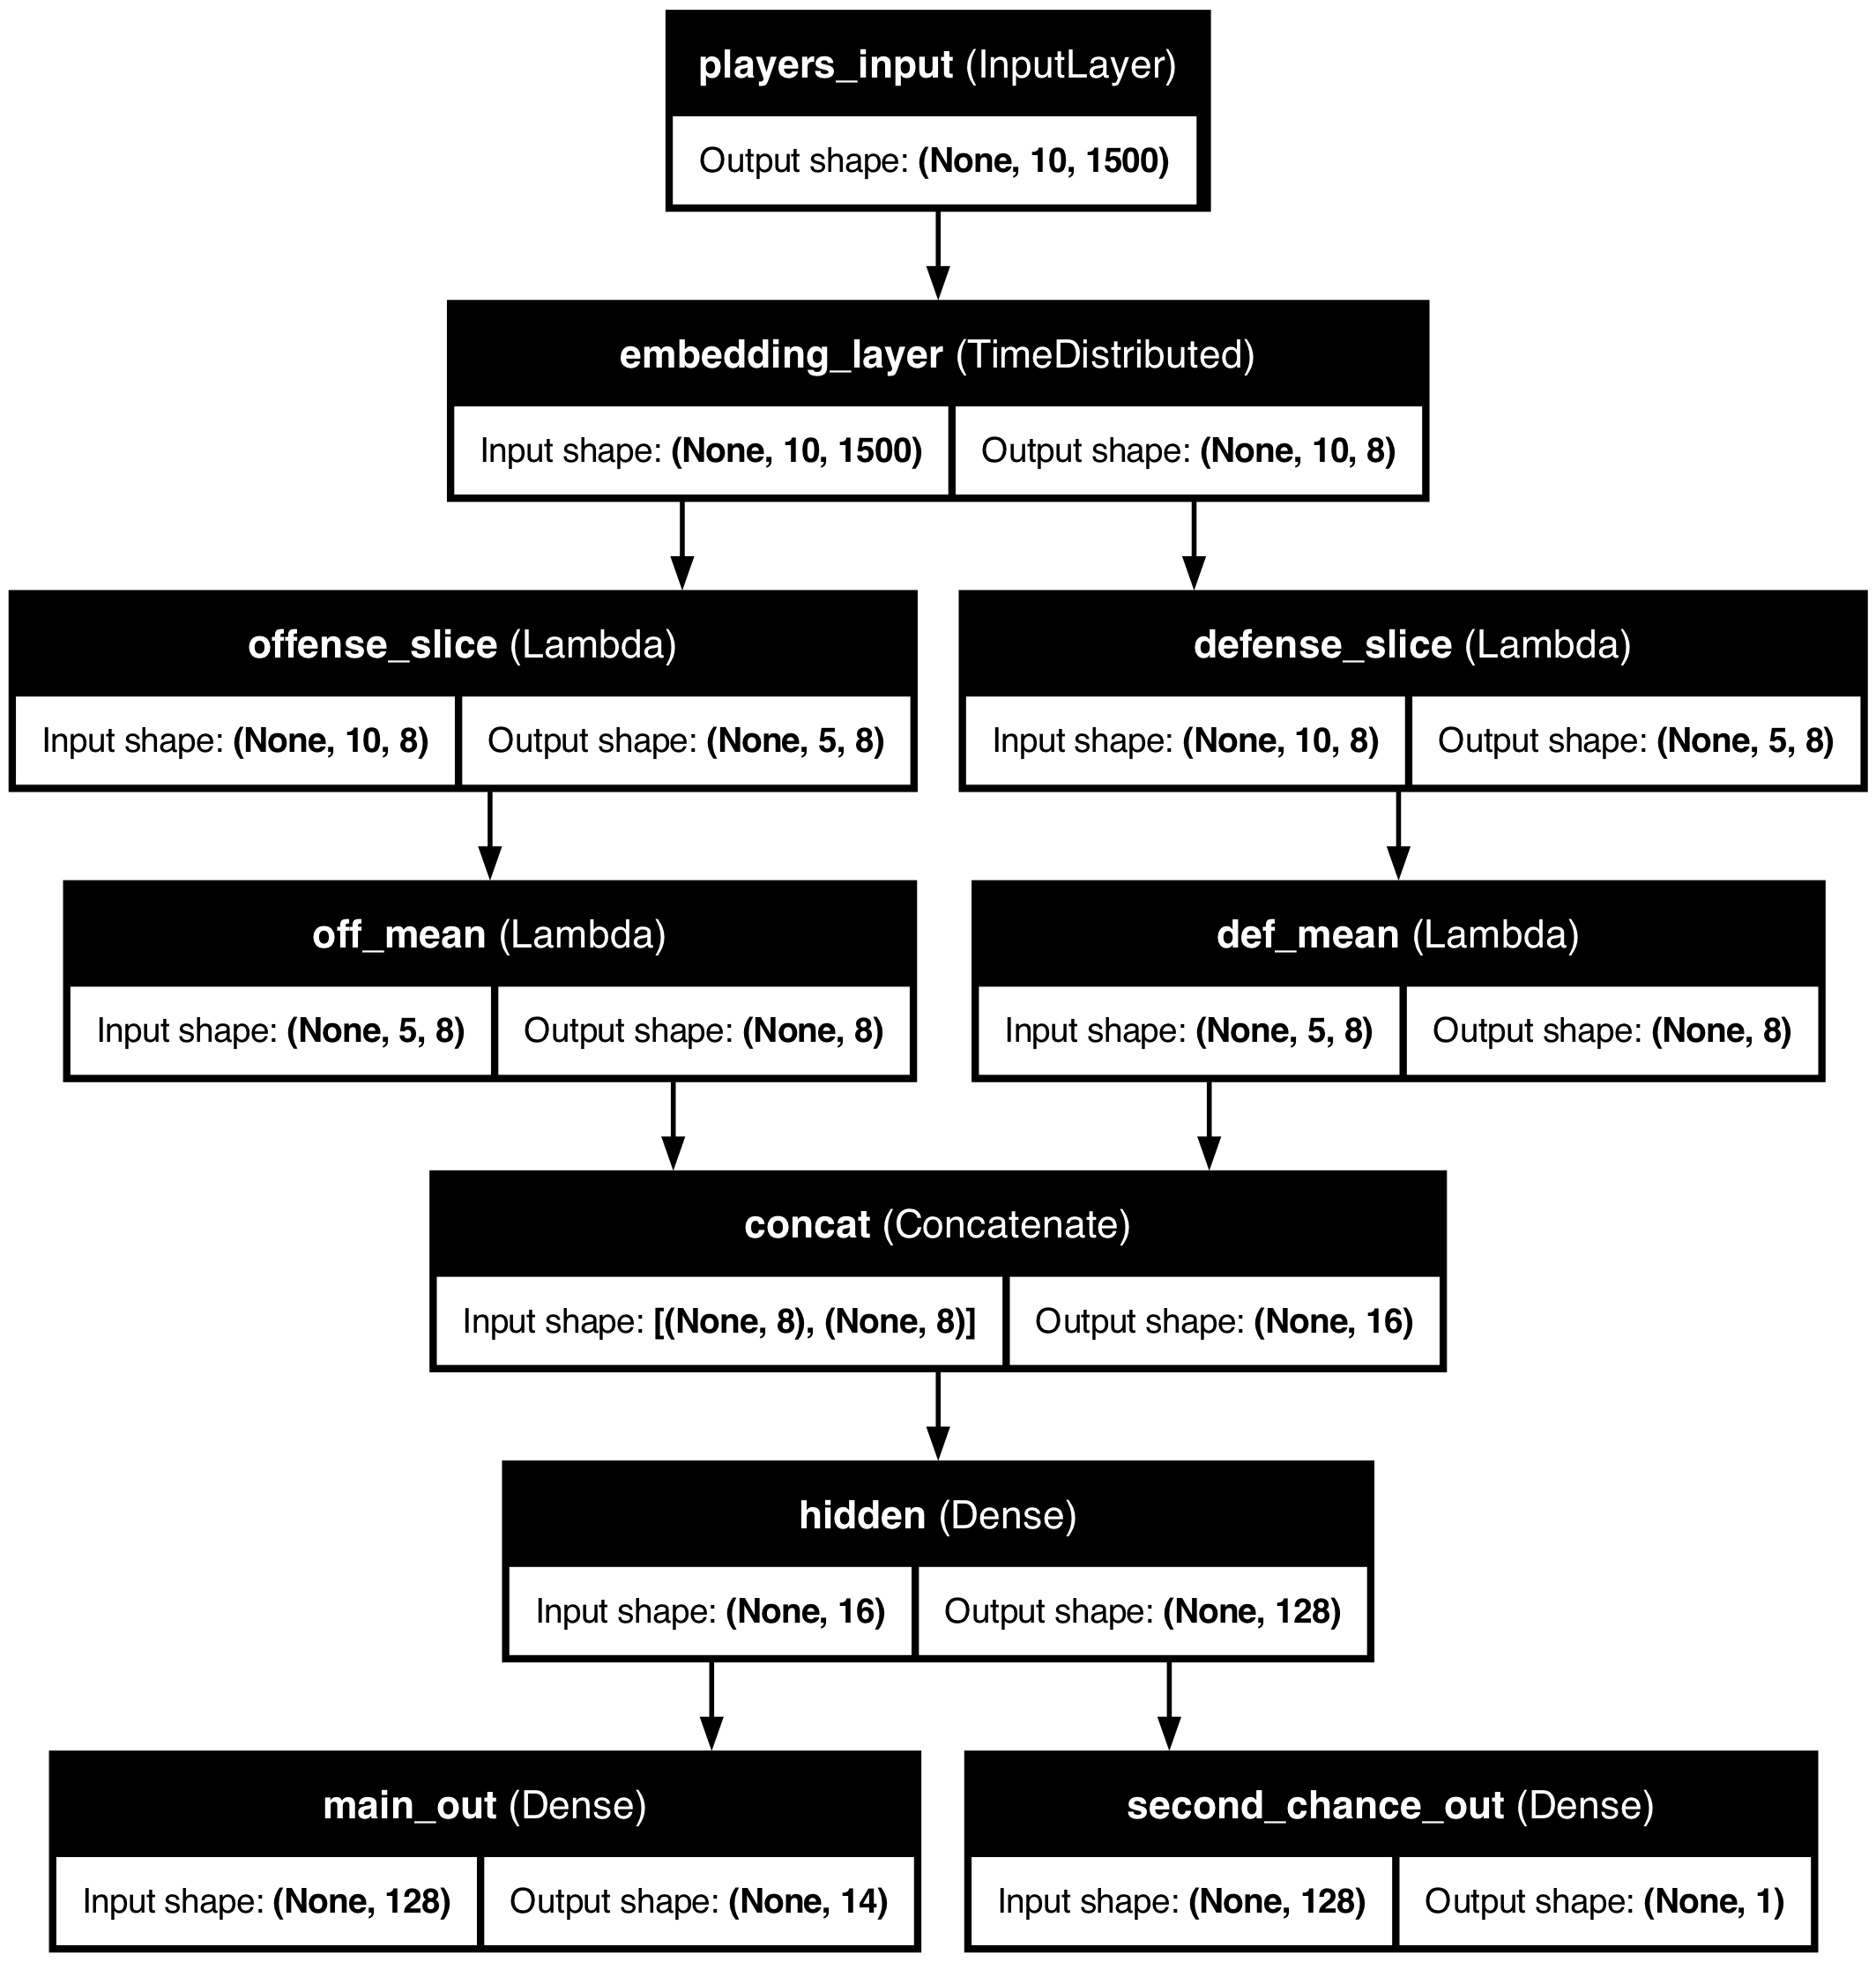

In [3]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Keras model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [13]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ players_input       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_embedding    │ (None, 10, 64)    │     98,752 │ players_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ offense_slice       │ (None, 5, 64)     │          0 │ player_embedding… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defense_slice       │ (None, 5, 64)     │          0 │ player_embedding… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ off_mean (Lambda)   │ (None, 64)        │          0 │ offense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ def_mean (Lambda)   │ (None, 64)        │          0 │ defense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 128)       │          0 │ off_mean[0][0],   │
│ (Concatenate)       │                   │            │ def_mean[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden (Dense)      │ (None, 128)       │     16,512 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_out (Dense)    │ (None, 14)        │      1,806 │ hidden[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ second_chance_out   │ (None, 1)         │        129 │ hidden[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,599 (1.34 MB)

 Trainable params: 117,199 (457.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,400 (915.63 KB)